In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import pickle
import copy

from torch.utils.data import Dataset, DataLoader
from torch import nn

from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from typing import Dict, Any, Tuple, List, Union, Sequence, Callable

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score


import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [8]:
col = 'FordA'

import sktime
from sktime.datasets import load_from_tsfile

x_train, y_train = load_from_tsfile("data/Ford_A/FordA_TRAIN.ts")
x_test, y_test = load_from_tsfile("data/Ford_A/FordA_TEST.ts")

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(array([-1,  1]), array([1846, 1755]))
(array([-1,  1]), array([681, 639]))


((3601, 500), (1320, 500), (3601,), (1320,))

In [9]:
def transform_X(X):
    np_data = []
    lens = []
    for i in range(len(X)):
        line = X.iloc[i, 0]
        lens.append(len(line))
        np_data.append(line)
        
    #print(np.mean(lens), np.std(lens))
    return np.array(np_data)

(36010, 50) (13200, 50) (36010, 1) (13200, 1)


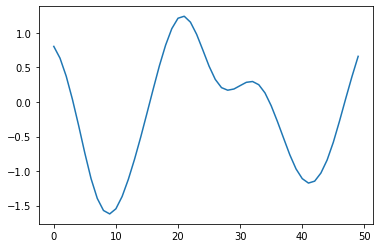

In [10]:
window = 50
len_seq = x_train.shape[1]
n_patches = len_seq//window

X_train = np.vstack([x_train[:, i:i+window] for i in range(n_patches)])
X_test = np.vstack([x_test[:, i:i+window] for i in range(n_patches)])

y_train = np.array([(int(y)+1) // 2 for y in y_train])
y_test = np.array([(int(y)+1) // 2 for y in y_test])

y_train = np.vstack([y_train.reshape(-1, 1) for i in range(n_patches)])
y_test = np.vstack([y_test.reshape(-1, 1) for i in range(n_patches)])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.plot(X_train[1])

In [11]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

# Modelling

In [12]:
class MyDataset(Dataset):
    def __init__(self, X, y, window=50):
        super().__init__()
        self.X = X
        self.y = y
        self.window=window

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        
#         start_ind = np.random.randint(0, len(X) - self.window)
#         X = X[start_ind:start_ind+self.window]
        X = X.reshape([-1, 1])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

    
BS = 64    
train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=BS, shuffle=True)
test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=BS, shuffle=False)

In [13]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        output = torch.sigmoid(output)
            
        return output

In [14]:
def train_step(model, loader, criterion, device, optimizer, scheduler=None):
    losses, n_batches = 0, 0
    model.train(True)
    for x, labels in loader:

        optimizer.zero_grad()
        x = x.to(device)
        labels = labels.reshape(-1, 1).to(device)
        
        y_out = model(x)
        loss = criterion(y_out, labels) 
        
        loss.backward()     
        optimizer.step()
        losses += loss
        n_batches += 1

    mean_loss = losses / n_batches

    if scheduler:
        scheduler.step()
    
    return mean_loss

def valid_step(model, loader, criterion, device):
    
    losses, n_batches = 0, 0
    model.eval()    
    for x, labels in loader:
        with torch.no_grad():
            x = x.to(device)
            labels = labels.reshape(-1, 1).to(device)

            y_out = model(x)
            loss = criterion(y_out, labels)
            losses += loss

            n_batches += 1

    mean_loss = losses / n_batches
    return mean_loss


def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1
    
def estimate_epoch(loader, model=None, device='cpu', round_=True, multiclass=False):
    
    y_all_pred = torch.tensor([])
    y_all_true = torch.tensor([])
    
    for X, y_true in loader:
        X = X.to(device)
        y_pred = model(X)
        
        if multiclass:
            y_pred = torch.argmax(y_pred, axis=1)
        else:
            y_pred = torch.round(y_pred)
        
        y_all_true = torch.cat((y_all_true, y_true.cpu().detach()), dim=0)
        y_all_pred = torch.cat((y_all_pred, y_pred.cpu().detach()), dim=0)
        
    y_all_pred = y_all_pred.numpy().reshape([-1, 1])
    y_all_true = y_all_true.numpy().reshape([-1, 1])
    
    acc, pr, rec, f1 = calculate_metrics(y_all_true, y_all_pred)
    
    return acc, pr, rec, f1

def train_procedure(model, train_loader, test_loader, criterion, optimizer, scheduler=None,
                   num_epochs=30, step_print=5):
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_step(model, train_loader, criterion, device, optimizer, scheduler)
        test_loss = valid_step(model, test_loader, criterion, device) 

        acc_train, pr_train, rec_train, f1_train = estimate_epoch(train_loader, model, device=device)
        acc_test, pr_test, rec_test, f1_test = estimate_epoch(test_loader, model, device=device)

        if epoch % step_print == 0:
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
#             plt.hist(y_test_pred)
#             plt.show()
            
    return model

def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1

def plotting(y_true, y_pred, window=1000):
    plt.figure(figsize=(8, 5))
    plt.plot(y_true[-window:], label = 'True')
    plt.plot(y_pred[-window:], label = 'Pred')
    plt.grid()
    plt.legend()
    plt.show()


In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)
X_train_tensor = X_train_tensor.reshape([X_train_tensor.shape[0],X_train_tensor.shape[1], 1])
X_test_tensor = X_test_tensor.reshape([X_test_tensor.shape[0],X_test_tensor.shape[1], 1])

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

## Stop here

In [2]:
# device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# #device = 'cpu'

# num_epochs = 15
# #print(num_epochs)
# LR = 0.001

# HIDDEN_DIM = 50
# OUTPUT_DIM = 1
# N_LAYERS = 1
# DROPOUT = 0.3

# for model_id in range(5):
#     print(model_id)
#     torch.manual_seed(model_id)

#     model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

#     criterion = torch.nn.BCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)
    
#     model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
#                 num_epochs=15, step_print=5)
    
#     torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{model_id}_{col}.pth') 

# Getting adv Data

In [16]:
def fgsm_attack(loss_val, x, eps):
    
    grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
    x_adv = x.data + eps * torch.sign(grad_)
    return x_adv
    
def fgsm_reg_attack(loss_val, x, eps, alpha):
    
    x_anchor = x[:, 1:-1]
    x_left = x[:, 2:]
    x_right = x[:, :-2]
    x_regular = (x_left + x_right) / 2
    loss_reg = torch.sum((x_anchor - x_regular.detach()) ** 2, dim=list(range(1, len(x.shape))))
    
    loss = loss_val - alpha * torch.mean(loss_reg)
    grad_ = torch.autograd.grad(loss, x, retain_graph=True)[0]
    x_adv = x.data + eps * (torch.sign(grad_))

    return x_adv


def attack_one_iter(
        model: nn.Module,  # model for attack
        loader: DataLoader,  # dataloader with data
        criterion: nn.Module,
        attack_fun,
        attack_params,
        device='cpu',
        train_mode=False):  # params_dict with eps and iter number

    """
    Applies 1 iteration of ifgsm adversarial attack to data
    :param model: model to get grad
    :param loader: dataloader with data
    :param criterion: loss function to calculate gradient for attack
    :param eps: the strengh of attack
    :param train_mode: bool to change mode of the model: should be False,
                       but RNN layers can't calculate grad with False value, so need to be set as True
    :return: x_adv_tensor - adversarial data,
            all_y_true - true labels,
            all_preds - predinctions before attack,
            all_preds_adv - predinctions on attacked data
    """
    model.train(train_mode)
    req_grad(model, state=False)  # detach all model's parameters

    all_y_true = []  # logging y_true for rebuilding dataloader and calculation difference with preds
    all_preds = []  # logging predictions original for calculation difference with data
    all_preds_adv = []  # logging predictions for calculation difference with data
    x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

    for x, y_true in loader:
        all_y_true.extend(y_true.detach().data.numpy())

        x.grad = None
        x.requires_grad = True

        # prediction for original input
        x = x.to(device, non_blocking=True)
        y_true = y_true.to(device)
        
        y_pred = model(x)

        # attack for adv input
        loss_val = criterion(y_pred, y_true.reshape(-1, 1))
        x_adv = attack_fun(loss_val, x, **attack_params)
        x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

        # assert (x_adv == x).sum() == 0, "Data doesn't change after attack"
        all_preds.extend(y_pred.cpu().detach().data.numpy())

        # prediction for adv input
        with torch.no_grad():
            y_pred_adv = model(x_adv)
            all_preds_adv.extend(y_pred_adv.cpu().detach().data.numpy())

        # assert (y_pred_adv == y_pred).sum() == 0, "Predicitions doesn't change after attack"

    return x_adv_tensor, all_y_true, all_preds, all_preds_adv


def attack_iterations_data(model: nn.Module,
                     loader: DataLoader,
                     dataset_class: Dataset,
                     criterion: nn.Module,
                     attack_fun,
                     attack_params,
                     n_steps: int,
                     device='cpu',
                     train_mode=False,
                     ):

    for iter_ in tqdm(range(n_steps)):

        # attack
        x_adv_tensor, y_true, preds_original, preds_adv = attack_one_iter(model=model, 
                                                                          loader=loader, 
                                                                          criterion=criterion, 
                                                                          attack_fun=attack_fun,
                                                                          attack_params=attack_params, 
                                                                          device=device, 
                                                                          train_mode=train_mode)

        # rebuilding dataloader for new iteration
        it_dataset = dataset_class(x_adv_tensor, torch.tensor(y_true))
        loader = DataLoader(it_dataset, batch_size=loader.batch_size)

    return torch.tensor(x_adv_tensor).detach(), torch.tensor(y_true).detach()


def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

def prepare_adv_data(
        model: nn.Module,  # model for attack
        loader: DataLoader,  # dataloader with data
        criterion: nn.Module,
        attack_func,
        attack_params,
        device='cpu',
        train_mode=False):  # params_dict with eps and iter number

    model.train(train_mode)
    req_grad(model, state=False)  # detach all model's parameters

    all_y_true = torch.tensor([]) # logging y_true for rebuilding dataloader and calculation difference with preds
    x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

    for x, y_true in loader:
        
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        x.grad = None
        x.requires_grad = True

        # prediction for original input
        x = x.to(device, non_blocking=True)
        y_true = y_true.to(device)

        y_pred = model(x)

        # attack for adv input
        loss_val = criterion(y_pred, y_true.reshape(-1, 1))
        x_adv = attack_fun(loss_val, x, **attack_params)
        x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

    return x_adv_tensor.detach(), all_y_true.detach()


def prepare_disc_data(model, 
                      loader, 
                      dataset_class,
                      X_tensor, 
                      criterion,
                      attack_fun,
                      attack_params, 
                      n_steps,
                      device, 
                      batch_size,
                      train_mode=True):
    

    X_adv, y_adv = attack_iterations_data(model, loader, dataset_class, criterion, attack_fun, attack_params,
                                          n_steps, device, batch_size, train_mode=train_mode)
    
    
    disc_labels_zeros = torch.zeros((len(X_tensor), 1)) #True label class
    disc_labels_ones = torch.ones(y_adv.shape) #True label class
    
    new_x = torch.concat([X_tensor, X_adv], dim=0)
    new_y = torch.concat([disc_labels_zeros, disc_labels_ones], dim=0)
    
    disc_loader = DataLoader(dataset_class(new_x, new_y), batch_size=BS, shuffle=True)
    
    return disc_loader

In [17]:
class HideAttackExp:
    def __init__(self, attack_model, train_loader, test_loader, attack_train_params, 
                 attack_test_params, discriminator_model, disc_train_params, multiclass=False):
        
        self.attack_loaders = {'train': train_loader,
                       'test': test_loader}
        self.attack_train = {'train':IterGradAttack(attack_model, train_loader, **attack_train_params),
                             'test': IterGradAttack(attack_model, test_loader, **attack_test_params)}
        self.disc_loaders = dict()
        
        self.attack_train_params = attack_train_params
        self.attack_test_params = attack_test_params
        
        #TO DO
        self.eps = attack_train_params
        self.alpha = None
        if 'alpha' in 
        self.n_iters = n_iters
        self.multiclass = multiclass
        
        self.attack_model = attack_model
        self.disc_model = discriminator_model
        
        self.disc_criterion = torch.nn.BCELoss()
        self_disc_n_epoch = disc_train_params['n_epoch']
        self.disc_batch_size = 64
        self.disc_optimizer = disc_train_params['optimizer']
        if 'scheduler' in disc_train_params.keys():
            self.disc_scheduler = disc_train_params['scheduler']
        else:
            self.disc_scheduler = None

        self.attack_device = next(classic_model.parameters()).device
        self.disc_device = next(discriminator_model.parameters()).device
    
    def _generate_adv_data(self, mode='train', batch_size=64):
        
        self.disc_batch_size = batch_size

        X_adv, y_adv = self.attack_train[mode].run_iterations()
        X_orig = self.loaders[mode].dataset.X
    
        disc_labels_zeros = torch.zeros((len(X_orig), 1)) #True label class
        disc_labels_ones = torch.ones(y_adv.shape) #True label class

        new_x = torch.concat([X_orig, X_adv], dim=0)
        new_y = torch.concat([disc_labels_zeros, disc_labels_ones], dim=0)

        suffle_status = mode == 'train'
        disc_loader = DataLoader(dataset_class(new_x, new_y), batch_size=batch_size, shuffle=suffle_status)
        self.disc_loaders[mode] = disc_loader
        return disc_loader
    
    def get_disc_dataloaders(self):
        self._generate_adv_data('train')
        self._generate_adv_data('test')
        
    def _logging_train_disc(self, data, mode='train'):
        
        for metric in self.dict_logging[mode].keys():
            self.dict_logging[mode][metric].append(data[metric])
    
    def train_discriminator(self):
        metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'balance']
        self.dict_logging = {'train': {metric:[] for metric in metric_names},
                       'test': {metric:[] for metric in metric_names}}

        for epoch in tqdm(range(self.disc_num_epochs)):
            train_metrics_epoch = self._train_step()
            train_metrics_epoch = {met_name:met_val for met_name, met_val
                                   in zip(metric_names, train_metrics_epoch)}
            self._logging_train_disc(train_metrics_epoch, mode='train')
            
            test_metrics_epoch = self._valid_step() 
            test_metrics_epoch = {met_name:met_val for met_name, met_val 
                       in zip(metric_names, test_metrics_epoch)}
            self._logging_train_disc(test_metrics_epoch, mode='test')
            
    
    def _train_step(self):
        losses, n_batches = 0, 0
        
        y_all_pred = torch.tensor([])
        y_all_true = torch.tensor([])
        
        model.train(True)
        for x, labels in self.disc_loaders['train']:

            self.disc_optimizer.zero_grad()
            x = x.to(self.disc_device)
            labels = labels.reshape(-1, 1).to(self.disc_device)

            y_out = self.disc_model(x)
            
            loss = self.disc_criterion(y_out, labels) 

            loss.backward()     
            self.disc_optimizer.step()
            losses += loss
            n_batches += 1
            
            if multiclass:
                y_pred = torch.argmax(y_pred, axis=1)
            else:
                y_pred = torch.round(y_pred)

            y_all_true = torch.cat((y_all_true, y_true.cpu().detach()), dim=0)
            y_all_pred = torch.cat((y_all_pred, y_pred.cpu().detach()), dim=0)

        mean_loss = losses / n_batches

        if self.disc_scheduler:
            self.disc_scheduler.step()
            
        y_all_pred = y_all_pred.numpy().reshape([-1, 1])
        y_all_true = y_all_true.numpy().reshape([-1, 1])

        acc, pr, rec, f1 = self.calculate_metrics(y_all_true, y_all_pred)
        balance = np.sum(y_all_pred) / len(y_all_pred)
        return mean_loss, acc, pr, rec, f1, balance


    def _valid_step(self):
        
        y_all_pred = torch.tensor([])
        y_all_true = torch.tensor([])
        
        losses, n_batches = 0, 0
        model.eval()    
        for x, labels in self.disc_loaders['test']:
            with torch.no_grad():
                x = x.to(self.disc_device)
                labels = labels.reshape(-1, 1).to(self.disc_device)

                y_out = self.disc_model(x)
                loss = self.disc_criterion(y_out, labels)
                losses += loss

                n_batches += 1

        mean_loss = losses / n_batches
        
        y_all_pred = y_all_pred.numpy().reshape([-1, 1])
        y_all_true = y_all_true.numpy().reshape([-1, 1])

        acc, pr, rec, f1 = self.calculate_metrics(y_all_true, y_all_pred)
        balance = np.sum(y_all_pred) / len(y_all_pred)
        return mean_loss, acc, pr, rec, f1, balance


    def calculate_metrics(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        pr = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        return acc, pr, rec, f1


SyntaxError: invalid syntax (<ipython-input-17-9244b749d221>, line 17)

In [18]:
# attack model loading
model_id = 0
path_to_saves = 'checkpoints/Ford_A/'

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

attack_model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
model_path = path_to_saves + f'model_{model_id}_{col}.pth'
attack_model.load_state_dict(copy.deepcopy(torch.load(model_path)))

<All keys matched successfully>

In [ ]:
attack_train_params = {'attack_func':fgsm_attack, 
                     'attack_params':{'eps':0.03}, 
                     'criterion':torch.nn.BCELoss(), 
                     'n_steps':10}
attack_test_params = attack_train_params



experiment = HideAttackExp(attack_model, train_loader, test_loader, attack_train_params, 
                           attack_test_params, discriminator_model, disc_train_params):

In [20]:
# old

In [19]:
eps = 0.03
alpha = 0.001 

n_steps = 1

dataset = MyDataset
criterion = torch.nn.BCELoss()
batch_size = 256
n_objects = y_train.shape[0]
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
train_mode=True

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

attack_fun = fgsm_attack
attack_params = {'eps':eps}

attack_fun_test = fgsm_attack
attack_params_test = {'eps':eps}

model_id = 0
    
path_to_saves = 'checkpoints/Ford_A/'

model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
model_path = path_to_saves + f'model_{model_id}_{col}.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

train_disc_loader = prepare_disc_data(model, train_loader, dataset, X_train_tensor, criterion, 
                                      attack_fun, attack_params, n_steps=n_steps, device=device, 
                                      batch_size=batch_size, train_mode=train_mode)

test_disc_loader = prepare_disc_data(model, test_loader, dataset, X_test_tensor, criterion, 
                                     attack_fun_test, attack_params_test, n_steps=n_steps, device=device, 
                                     batch_size=batch_size, train_mode=train_mode)
    

TypeError: attack_iterations_data() got multiple values for argument 'train_mode'

In [158]:
attack_fun = fgsm_reg_attack
attack_params = {'eps':eps, 'alpha':alpha}

attack_fun_test = fgsm_reg_attack
attack_params_test = {'eps':eps, 'alpha':alpha}


path_to_saves = 'checkpoints/Ford_A/'

model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
model_path = path_to_saves + f'model_{model_id}_{col}.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

train_disc_loader_reg = prepare_disc_data(model, train_loader, dataset, X_train_tensor, criterion, 
                                      attack_fun, attack_params, n_steps=n_steps, device=device, 
                                      batch_size=batch_size, train_mode=train_mode)

test_disc_loader_reg = prepare_disc_data(model, test_loader, dataset, X_test_tensor, criterion, 
                                     attack_fun_test, attack_params_test, n_steps=n_steps, device=device, 
                                     batch_size=batch_size, train_mode=train_mode)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [159]:
# params for training

model_id = 0
torch.manual_seed(model_id)

device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

num_epochs = 20
LR = 0.001
step_lr = 12

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.3

In [160]:
def train_procedure_log(model, train_loader, test_loader, criterion, optimizer, scheduler=None,
                   num_epochs=30, step_print=5):
    
    dict_logging = {'test_acc':[], 'test_f1':[]}
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_step(model, train_loader, criterion, device, optimizer, scheduler)
        test_loss = valid_step(model, test_loader, criterion, device) 

        acc_train, pr_train, rec_train, f1_train = estimate_epoch(train_loader, model, device=device)
        acc_test, pr_test, rec_test, f1_test = estimate_epoch(test_loader, model, device=device)
        
        dict_logging['test_acc'].append(acc_test)
        dict_logging['test_f1'].append(f1_test)

        if epoch % step_print == 0:
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
            
    return model, dict_logging

In [ ]:
dict_metr_all_orig = dict()

for model_id in tqdm(range(5)):
    torch.manual_seed(model_id)

    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_lr, gamma=0.1)

    model, dict_metrics_orig = train_procedure_log(model, train_disc_loader, test_disc_loader, 
                             criterion, optimizer, num_epochs=num_epochs, step_print=20)
    
    dict_metr_all_orig[model_id] = dict_metrics_orig

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.500; f1_train 0.667; test loss: 0.693; acc_test 0.500; f1_test 0.667;


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.500; f1_train 0.667; test loss: 0.693; acc_test 0.500; f1_test 0.667;


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.694; acc_train 0.500; f1_train 0.664; test loss: 0.693; acc_test 0.500; f1_test 0.664;


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.500; f1_train 0.418; test loss: 0.693; acc_test 0.500; f1_test 0.410;


In [ ]:
dict_metr_all_reg = dict()

for model_id in tqdm(range(5)):
    torch.manual_seed(model_id)
    
    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_lr, gamma=0.1)

    model, dict_metrics_reg = train_procedure_log(model, train_disc_loader_reg, test_disc_loader_reg, 
                             criterion, optimizer, num_epochs=num_epochs, step_print=20)
    dict_metr_all_reg[model_id] = dict_metrics_reg
## reg_params

In [ ]:
# TO DO: графики для 5 экспериментов

In [ ]:
metric_name = 'test_f1'

plt.figure(figsize=(10, 7))

metrics_diff_list = list()

for model_id in range(5):
    metric_orig = dict_metr_all_orig[model_id][metric_name]
    metric_reg = dict_metr_all_reg[model_id][metric_name]
    
    iters = list(range(len(metric_reg)))
    metric_diff = np.array(metric_orig) - np.array(metric_reg)
    metrics_diff_list.append(metric_diff)
    
    plt.plot(iters, metric_diff, label=model_id)
    
    
metrics_diff_mean = np.mean(np.array(metrics_diff_list), axis=0)
plt.plot(iters, metrics_diff_mean, linewidth=2, linestyle='--', label='Mean')    

plt.grid()
plt.legend()
plt.show()

# Эксперимент с силой атаки

In [ ]:
# to do одношаговая iFGSM
# to do взять более сильную alpha

In [ ]:
generation_params = {'dataset': MyDataset(),
                     'criterion': torch.nn.BCELoss(),
                     'train_loader': train_loader,
                     'test_loader': train_loader,
                     
                     ''}

attack_fun = {'train': fgsm_attack,
             'test': fgsm_attack
             }


attack_params = {'train': {'eps': eps, 'n_steps': n_steps},
                'test': {'eps': eps, 'n_steps': n_steps},
                }

def experiment_disc(attack_fun: Dict,
               attack_params: Dict,
                    loaders: Dict,
               model_for_attack,
               model_disc,
               train_params):
    
    train_disc_loader = prepare_disc_data(model, train_loader, dataset, criterion, 
                                      attack_fun, attack_params, n_steps=n_steps, device=device, 
                                      batch_size=batch_size, train_mode=train_mode)

    test_disc_loader = prepare_disc_data(model, test_loader, dataset, criterion, 
                                     attack_fun_test, attack_params_test, n_steps=n_steps, device=device, 
                                     batch_size=batch_size, train_mode=train_mode)
    
    

In [ ]:
eps = 0.03
alpha = 0.01 

n_steps = 10

dataset = MyDataset
criterion = torch.nn.BCELoss()
batch_size = 256
n_objects = y_train.shape[0]
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
train_mode=True

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

attack_fun = fgsm_attack
attack_params = {'eps':eps}

attack_fun_test = fgsm_attack
attack_params_test = {'eps':eps}

model_id = 0
    
path_to_saves = 'checkpoints/Ford_A/'

model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
model_path = path_to_saves + f'model_{model_id}_{col}.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

train_disc_loader = prepare_disc_data(model, train_loader, dataset, X_train_tensor, criterion, 
                                      attack_fun, attack_params, n_steps=n_steps, device=device, 
                                      batch_size=batch_size, train_mode=train_mode)

test_disc_loader = prepare_disc_data(model, test_loader, dataset, X_test_tensor, criterion, 
                                     attack_fun_test, attack_params_test, n_steps=n_steps, device=device, 
                                     batch_size=batch_size, train_mode=train_mode)
    